# Báo cáo đồ án cuối kỳ môn Lập trình Song song
## Hệ thống học đặc trưng không giám sát dựa trên Autoencoder
---------------

## Nhóm 2
- Lê Minh Quân (MSSV: 22120291)
- Liêu Hải Lưu Danh (MSSV: 22120459)
- Phan Nguyễn Minh Khôi (MSSV: 22120166)

### I. Chuẩn bị môi trường

In [1]:
!git clone https://github.com/lhldanh/Autoencoder-based-unsupervised-feature-learning-system.git
%cd Autoencoder-based-unsupervised-feature-learning-system/

Cloning into 'Autoencoder-based-unsupervised-feature-learning-system'...
remote: Enumerating objects: 494, done.
remote: Counting objects: 100% (269/269), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 494 (delta 181), reused 193 (delta 107), pack-reused 225 (from 1)
Receiving objects: 100% (494/494), 431.61 KiB | 5.14 MiB/s, done.
Resolving deltas: 100% (316/316), done.
/kaggle/working/Autoencoder-based-unsupervised-feature-learning-system


In [2]:
%mkdir -p build
%mkdir -p weights
%mkdir -p data
!wget https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz -O data/cifar-10-binary.tar.gz
!tar -xzvf data/cifar-10-binary.tar.gz -C data

--2025-12-20 15:34:47--  https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170052171 (162M) [application/x-gzip]
Saving to: ‘data/cifar-10-binary.tar.gz’

data/cifar-10-binar 100%[===================>] 162.17M  63.0MB/s    in 2.6s    

2025-12-20 15:34:50 (63.0 MB/s) - ‘data/cifar-10-binary.tar.gz’ saved [170052171/170052171]

cifar-10-batches-bin/
cifar-10-batches-bin/data_batch_1.bin
cifar-10-batches-bin/batches.meta.txt
cifar-10-batches-bin/data_batch_3.bin
cifar-10-batches-bin/data_batch_4.bin
cifar-10-batches-bin/test_batch.bin
cifar-10-batches-bin/readme.html
cifar-10-batches-bin/data_batch_5.bin
cifar-10-batches-bin/data_batch_2.bin


### **II. Báo cáo đồ án**
#### **1. Mô tả bài toán**
##### **1.1. Phát biểu bài toán**
- Xây dựng một mô hình **Convolutional Autoencoder** (CAE) sử dụng bộ dữ liệu CIFAR-10 để **học đặc trưng không giám sát (feature extraction)**, sau đó sử dụng các đặc trưng học được kết hợp với mô hình Support Vector Machine để thực hiện bài toán phân loại hình ảnh.


- Việc huấn luyện các mạng CNN **đòi hỏi khối lượng tính toán lớn**, đặc biệt là các phép nhân ma trận và tích chập.
    - **Hạn chế của CPU:** Xử lý tuần tự hoặc song song hạn chế, không đáp ứng được yêu cầu về thời gian huấn luyện thực tế cho dữ liệu lớn.

    - **Lợi thế của GPU:** Với kiến trúc gồm hàng nghìn lõi cuda cores, GPU cho phép thực hiện đồng thời rất rất nhiều phép tính dấu phẩy động.
    - **Mục tiêu tối ưu:** Đồ án này yêu cầu tự cài đặt các thuật toán bằng CUDA C++ để tối ưu hóa lập trình song song trên GPU

#### **1.2. Mô tả bộ dữ liệu**
##### **1.2.1. Thông số kỹ thuật**
- **Tên:** CIFAR-10 (Viện Nghiên cứu Nâng cao Canada).

- **Kích thước:** 60,000 ảnh màu (RGB).

- **Độ phân giải:** 32x32 pixels.

- **Số lượng lớp:** 10 lớp đối tượng (Máy bay, Ô tô, Chim, Mèo, Hươu, Chó, Ếch, Ngựa, Tàu thủy, Xe tải).

- **Phân chia dữ liệu:**

  - **Tập huấn luyện:** 50,000 ảnh.

  - **Tập kiểm tra:** 10,000 ảnh.
##### **1.2.2. Minh hoạ bộ dữ liệu**

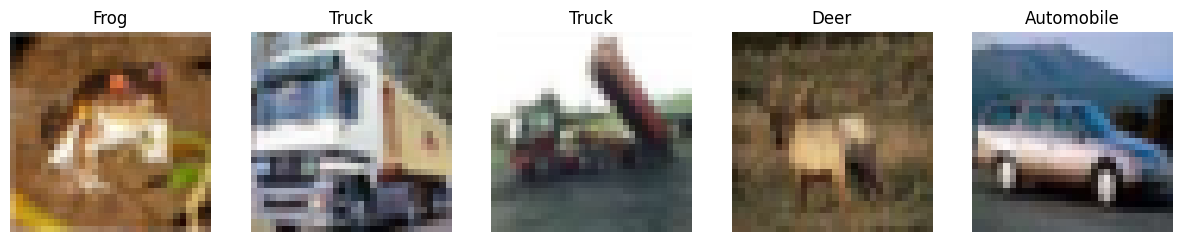

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

file_path = 'data/cifar-10-batches-bin/data_batch_1.bin'

def show_cifar_images():
    # Kiểm tra file có tồn tại không
    if not os.path.exists(file_path):
        print(f"Lỗi: Không tìm thấy file tại {file_path}")
        print("Hãy đảm bảo lệnh '!tar -xzvf ...' đã chạy thành công.")
        return

    with open(file_path, 'rb') as f:
        content = f.read()
    data = np.frombuffer(content, dtype=np.uint8)
    data = data.reshape(-1, 3073)
    labels = data[:, 0]
    images_flat = data[:, 1:]

    images = images_flat.reshape(-1, 3, 32, 32)

    images = images.transpose(0, 2, 3, 1)

    class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                   'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

    plt.figure(figsize=(15, 3))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis('off')

    plt.show()

show_cifar_images()

##### **1.2.3. Tiền xử lý dữ liệu**
- Chuyển kiểu dữ liệu từ uint8 → float
- Áp dụng chuẩn hóa min-max

#### **1.3. Kiến trúc mạng Autoencoder**
##### **1.3.1. Sơ đồ kiến trúc:** Tuân thủ đúng kiến trúc được chỉ định trong yêu cầu đồ án

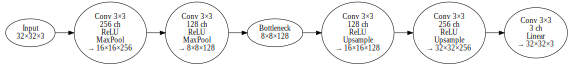

In [4]:
from graphviz import Digraph

dot = Digraph(format="png")
dot.attr(rankdir="LR", size="8,5")

# Input
dot.node("Input", "Input\n32×32×3")

# Encoder
dot.node("Conv1", "Conv 3×3\n256 ch\nReLU\nMaxPool\n→ 16×16×256")
dot.node("Conv2", "Conv 3×3\n128 ch\nReLU\nMaxPool\n→ 8×8×128")

# Bottleneck
dot.node("Bottle", "Bottleneck\n8×8×128")

# Decoder
dot.node("Conv3", "Conv 3×3\n128 ch\nReLU\nUpsample\n→ 16×16×128")
dot.node("Conv4", "Conv 3×3\n256 ch\nReLU\nUpsample\n→ 32×32×256")

# Output
dot.node("Out", "Conv 3×3\n3 ch\nLinear\n→ 32×32×3")

# Edges
dot.edges([
    ("Input", "Conv1"),
    ("Conv1", "Conv2"),
    ("Conv2", "Bottle"),
    ("Bottle", "Conv3"),
    ("Conv3", "Conv4"),
    ("Conv4", "Out")
])

dot

#### **1.4. Mục tiêu đồ án**
##### **1.4.1. Hiệu năng**
- Tăng tốc độ (Speedup): Đạt tốc độ huấn luyện nhanh hơn so với cài đặt C++ thuần chạy trên CPU.

- Độ chính xác: Giảm thiểu loss của Autoencoder xuống mức thấp nhất có thể, và độ chính xác ổn định khi phân loại ảnh với SVM
##### **1.4.2. Kỹ thuật**
*Nắm rõ một số kỹ thuật tối ưu hóa nâng cao khi lập trình song song với GPU như:*
- **Shared Memory Tiling:** Sử dụng bộ nhớ chia sẻ (__shared__) để giảm độ trễ truy cập bộ nhớ toàn cục (Global Memory) trong các phép nhân ma trận (GEMM).
- **Convert to Matrix Multiplication**: Chuyển đổi bài toán tích chập (Convolution) thành phép nhân ma trận (Matrix Multiplication) để tận dụng sức mạnh của các kernel GEMM tối ưu.
- **Register Blocking (Thread Coarsening):** Tối ưu hóa sâu hơn bằng cách sử dụng thanh ghi (float acc[THREAD_M][THREAD_N]) để lưu trữ kết quả trung gian, giảm áp lực lên Shared Memory và tăng thông lượng tính toán.
- **Parallel Reduction:** Thực hiện kỹ thuật khử (reduction) trên cây nhị phân trong Shared Memory để tính hàm mất mát (MSE Loss) hiệu quả.
- **Kernel Fusion:** Gộp các thao tác tính toán liên tiếp như GEMM + Bias Add + ReLU vào một kernel duy nhất để giảm băng thông bộ nhớ và chi phí khởi chạy kernel
- **Vectorized Memory Access:** Sử dụng kiểu dữ liệu float4 để đọc/ghi 128-bit dữ liệu trong một lệnh, tối đa hóa băng thông bộ nhớ trong các tác vụ SGD và khởi tạo.
- **Pinned (Page-Locked) Memory:** Sử dụng CUDA Streams và Pinned Memory (cudaMallocHost) để thực hiện song song việc nạp dữ liệu (H2D) và tính toán (Compute), che giấu độ trễ truyền tải dữ liệu.
##### **1.4.3. Tiêu chí thành công**
- Chương trình biên dịch và chạy không có lỗi.
- Hàm mất mát giảm đều đặn qua các epoch.
- Chứng minh được hiệu quả của việc tối ưu hóa.
- Phân loại hình ảnh với SVM đạt độ chính xác tốt (accuracy > 60%)

### **2. Kết quả triển khai**
#### **2.1. Cài đặt trên CPU**

In [6]:
# !g++ -std=c++17 -O3 src/train_cpu.cpp src/cifar10_dataset.cpp src/kernels_cpu.cpp -I include -o build/cpu_train
# !./build/cpu_train

Thời gian training của CPU đối với setting (max_image = 96, batch_size = 32, lr = 0.001, epochs = 5) là:
- Khoảng 110 giây cho 1 epochs
- Tổng thời gian là 553.144 giây

#### **2.2. Cài đặt GPU cơ bản**

In [6]:
!ls

benchmark_temp.ipynb  data     README.md     Report_new.ipynb  weights
build		      include  Report.ipynb  src


In [7]:
!nvcc -arch=sm_75 -o build/train_gpu src/train_gpu.cu src/cifar10_dataset.cpp src/kernel.cu src/host.cu -I include/
%cd build
!./train_gpu
%cd ..

/kaggle/working/Autoencoder-based-unsupervised-feature-learning-system/build
--- Loading CIFAR-10 Dataset ---
Loaded batch: ../data/cifar-10-batches-bin/data_batch_1.bin | Current Total: 10000
Loaded batch: ../data/cifar-10-batches-bin/data_batch_2.bin | Current Total: 20000
Loaded batch: ../data/cifar-10-batches-bin/data_batch_3.bin | Current Total: 30000
Loaded batch: ../data/cifar-10-batches-bin/data_batch_4.bin | Current Total: 40000
Loaded batch: ../data/cifar-10-batches-bin/data_batch_5.bin | Current Total: 50000
Loaded batch: ../data/cifar-10-batches-bin/test_batch.bin | Current Total: 10000
Successfully loaded 50000 train images and 10000 test images.
Applying Min-Max normalization [0, 255] -> [0, 1]...
Normalization complete.
--- START TRAINING (CUDA) ---
Batch Size: 32, Epochs: 5, Learning Rate: 0.001
Max Images: 96

Epoch 1 Done. Avg Loss: 0.265066 | Time: 0.971556s

Epoch 2 Done. Avg Loss: 0.25996 | Time: 1.96721s

Epoch 3 Done. Avg Loss: 0.254953 | Time: 2.96651s

Epoch 4 

Thời gian training của Naive GPU đối với setting (max_image = 96, batch_size = 32, lr = 0.001, epochs = 5) là:
- Khoảng 0.98 giây cho 1 epochs
- Tổng thời gian là ~4.9 giây

#### **2.3. Cài đặt GPU đã tối ưu hóa**

In [8]:
!nvcc -arch=sm_75 -o build/train_gpu_optimize_all src/train_gpu_optimize_all.cu src/cifar10_dataset.cpp src/optimize_kernel.cu src/host.cu -I include/
%cd build
!./train_gpu_optimize_all
%cd ..

/kaggle/working/Autoencoder-based-unsupervised-feature-learning-system/build
=== CUDA Autoencoder (Fused Backward Kernels) ===

GPU: Tesla T4
SMs: 40

--- Loading CIFAR-10 Dataset ---
Loaded batch: ../data/cifar-10-batches-bin/data_batch_1.bin | Current Total: 10000
Loaded batch: ../data/cifar-10-batches-bin/data_batch_2.bin | Current Total: 20000
Loaded batch: ../data/cifar-10-batches-bin/data_batch_3.bin | Current Total: 30000
Loaded batch: ../data/cifar-10-batches-bin/data_batch_4.bin | Current Total: 40000
Loaded batch: ../data/cifar-10-batches-bin/data_batch_5.bin | Current Total: 50000
Loaded batch: ../data/cifar-10-batches-bin/test_batch.bin | Current Total: 10000
Successfully loaded 50000 train images and 10000 test images.
Applying Min-Max normalization [0, 255] -> [0, 1]...
Normalization complete.
Images: 50000

Memory: 1779 MB

Training: 20 epochs, 1 batches (96 images)

Epoch 1/20 | Loss: 0.336317 | Time: 0.30s | 213 img/s
  W1[0:5]: -0.0532 -0.1323 -0.0486 0.0084 -0.0289 


Thời gian training của GPU khi sử dụng các kĩ thuật Advanced Optimization đối với setting (max_image = 96, batch_size = 32, lr = 0.001, epochs = 5) là:

Khoảng 0.2 giây cho 1 epochs
Tổng thời gian là 1 giây

**Bảng tổng kết thời gian chạy**
| Phase | Training Time (s) | Speedup (vs CPU) |
|------|-------------------|------------------|
| CPU Baseline | 553.144 | 1.0× |
| Naive GPU | 4.932 | 112.2× |
| Optimized GPU  | 1.0 | 553.1× |


#### **Thời gian khi áp dụng từng kỹ thuật**

In [12]:
# Baseline
!nvcc -arch=sm_75 -o build/train_gpu_baseline src/train_gpu_baseline.cu src/kernel.cu src/cifar10_dataset.cpp -I include/
%cd build
!./train_gpu_baseline
%cd ..

# Memory Pool
!nvcc -arch=sm_75 -o build/train_gpu_optimize_memory_pool src/train_gpu_optimize_memory_pool.cu src/kernel.cu src/cifar10_dataset.cpp -I include/
%cd build
!./train_gpu_optimize_memory_pool
%cd ..

# Double Buffering
!nvcc -arch=sm_75 -o build/train_gpu_optimize_double_buffer src/train_gpu_optimize_double_buffer.cu src/kernel.cu src/cifar10_dataset.cpp -I include/
%cd build
!./train_gpu_optimize_double_buffer
%cd ..

# Im2col
!nvcc -arch=sm_75 -o build/train_gpu_optimize_im2col src/train_gpu_optimize_im2col.cu src/kernel.cu src/optimize_kernel.cu src/cifar10_dataset.cpp -I include/
%cd build
!./train_gpu_optimize_im2col
%cd ..

# GEMM
!nvcc -arch=sm_75 -o build/train_gpu_optimize_gemm src/train_gpu_optimize_gemm.cu src/kernel.cu src/optimize_kernel.cu src/cifar10_dataset.cpp -I include/
%cd build
!./train_gpu_optimize_gemm
%cd ..

# Kernel Fusion
!nvcc -arch=sm_75 -o build/train_gpu_optimize_fused_kernels src/train_gpu_optimize_fused_kernels.cu src/kernel.cu src/optimize_kernel.cu src/cifar10_dataset.cpp -I include/
%cd build
!./train_gpu_optimize_fused_kernels
%cd ..

# CUDA Streams
!nvcc -arch=sm_75 -o build/train_gpu_optimize_cuda_streams src/train_gpu_optimize_cuda_streams.cu src/kernel.cu src/optimize_kernel.cu src/cifar10_dataset.cpp -I include/
%cd build
!./train_gpu_optimize_cuda_streams
%cd ..

# Pinned Memory
!nvcc -arch=sm_75 -o build/train_gpu_optimize_pinned_memory src/train_gpu_optimize_pinned_memory.cu src/kernel.cu src/optimize_kernel.cu src/cifar10_dataset.cpp -I include/
%cd build
!./train_gpu_optimize_pinned_memory
%cd ..

# All Optimizations
!nvcc -arch=sm_75 -o build/train_gpu_optimize_all src/train_gpu_optimize_all.cu src/kernel.cu src/optimize_kernel.cu src/cifar10_dataset.cpp -I include/
%cd build
!./train_gpu_optimize_all
%cd ..

/kaggle/working/Autoencoder-based-unsupervised-feature-learning-system/build
⏱️  train_gpu_baseline: 3.20039 seconds
/kaggle/working/Autoencoder-based-unsupervised-feature-learning-system
/kaggle/working/Autoencoder-based-unsupervised-feature-learning-system/build
⏱️  train_gpu_optimize_memory_pool: 2.8455s
/kaggle/working/Autoencoder-based-unsupervised-feature-learning-system
/kaggle/working/Autoencoder-based-unsupervised-feature-learning-system/build
⏱️  train_gpu_optimize_double_buffer: 3.18452s
/kaggle/working/Autoencoder-based-unsupervised-feature-learning-system
/kaggle/working/Autoencoder-based-unsupervised-feature-learning-system/build
⏱️  train_gpu_optimize_im2col: 2.85732s
/kaggle/working/Autoencoder-based-unsupervised-feature-learning-system
/kaggle/working/Autoencoder-based-unsupervised-feature-learning-system/build
⏱️  train_gpu_optimize_gemm: 2.84595s
/kaggle/working/Autoencoder-based-unsupervised-feature-learning-system
/kaggle/working/Autoencoder-based-unsupervised-feat

#### **2.4. Phân tích các kỹ thuật tối ưu hóa nâng cao đã sử dụng**

Dưới đây là phân tích chi tiết các kỹ thuật tối ưu hóa nâng cao được áp dụng trong file `train_gpu_optimize.cu`:

---

##### **2.4.1. Shared Memory Tiling**

**Mục đích và ý tưởng:**
Tiling là kỹ thuật chia ma trận lớn thành các **"tiles" (ô vuông)** nhỏ hơn để load vào **shared memory** - một loại bộ nhớ rất nhanh được chia sẻ giữa các threads trong cùng block. Thay vì mỗi thread đọc dữ liệu từ **global memory chậm**, toàn bộ block **hợp tác load** một tile vào shared memory, sau đó tất cả threads đều có thể **truy cập nhanh**. Điều này tận dụng tính chất **data reuse** trong phép nhân ma trận: mỗi element được **sử dụng nhiều lần**.

**Cách hoạt động:**
```cuda
// Load data vào shared memory
As[threadIdx.y][threadIdx.x] = (row < M && a_col < K) ? A[row * K + a_col] : 0.0f;
Bs[threadIdx.y][threadIdx.x] = (col < N && b_col < K) ? B[col * K + b_col] : 0.0f;
__syncthreads();

// Tính toán từ shared memory thay vì global memory
for (int k = 0; k < TILE_SIZE; ++k) {
    sum += As[threadIdx.y][k] * Bs[k][threadIdx.x];
}
```

**Lý do tối ưu:**
- **Giảm độ trễ truy cập bộ nhớ:** Shared memory có độ trễ ~100x thấp hơn global memory (~5ns vs ~500ns)
- **Tái sử dụng dữ liệu:** Mỗi phần tử được load 1 lần từ global memory nhưng sử dụng nhiều lần (TILE_SIZE lần)
- **Tăng băng thông:** Coalesced memory access khi load vào shared memory, giảm số lần truy cập global memory từ O(M×N×K) xuống O((M×N×K)/TILE_SIZE)

---

##### **2.4.2. Register Blocking (Thread Coarsening)**


**Mục đích và ý tưởng:**
Thay vì mỗi thread chỉ tính 1 output element, kỹ thuật này cho phép **mỗi thread tính nhiều elements (4×4 = 16 outputs)**. Các kết quả trung gian được lưu trong **registers** - loại **bộ nhớ nhanh nhất** trên GPU. Điều này giảm số lần truy cập shared memory, tăng **instruction-level parallelism** (GPU có thể thực thi nhiều lệnh đồng thời), và cho phép compiler **tối ưu tốt hơn**. Đây là optimization tiếp theo sau tiling để **đẩy hiệu năng lên cao nhất**.

**Cách hoạt động:**
```cuda
// Mỗi thread tính THREAD_M × THREAD_N outputs (4×4 = 16 elements)
float acc[THREAD_M][THREAD_N] = {0.0f};

// Load vào registers
float a_reg[THREAD_M], b_reg[THREAD_N];
for (int m = 0; m < THREAD_M; ++m)
    a_reg[m] = As[ki][ty * THREAD_M + m];
for (int n = 0; n < THREAD_N; ++n)
    b_reg[n] = Bs[ki][tx * THREAD_N + n];

// Tính toán từ registers
for (int m = 0; m < THREAD_M; ++m)
    for (int n = 0; n < THREAD_N; ++n)
        acc[m][n] += a_reg[m] * b_reg[n];
```

**Lý do tối ưu:**
- **Giảm áp lực lên shared memory:** Mỗi thread xử lý nhiều elements, giảm số lần đọc/ghi shared memory
- **Tăng instruction-level parallelism:** GPU có thể execute nhiều phép toán từ registers đồng thời
- **Tăng occupancy:** Giảm shared memory usage cho phép nhiều blocks chạy đồng thời
- **Hiệu quả với large matrices:** Kernel này được chọn tự động khi M, N, K >= 64

---

##### **2.4.3. Kernel Fusion (GEMM + Bias + ReLU)**


**Mục đích và ý tưởng:**
Kernel fusion **gộp nhiều operations liên tiếp** thành **một kernel duy nhất**. Thay vì: (1) Chạy GEMM → ghi ra memory → (2) Đọc lại → cộng bias → ghi ra → (3) Đọc lại → ReLU → ghi ra, ta thực hiện tất cả **ngay trong registers** của một kernel: tính GEMM → cộng bias → ReLU → **ghi ra một lần**. Điều này **giảm drastically memory traffic** (bottleneck chính của GPU), **giảm kernel launch overhead**, và **tăng data locality**.

**Cách hoạt động:**
```cuda
// Thay vì 3 kernel calls riêng biệt:
// gemm() → add_bias() → relu()

// Gộp thành 1 kernel:
if (row < M && col < N) {
    float val = sum + bias[col];  // Fused bias addition
    C[row * N + col] = relu ? fmaxf(val, 0.0f) : val;  // Fused ReLU
}
```

**Lý do tối ưu:**
- **Giảm kernel launch overhead:** Từ 3 kernel calls xuống 1 call (mỗi launch ~5-10μs)
- **Giảm memory bandwidth:** Không cần ghi intermediate results vào global memory rồi đọc lại
- **Tăng data locality:** Kết quả GEMM được xử lý ngay trong registers trước khi ghi ra memory
- **Ước tính speedup:** ~1.5-2x so với 3 kernels riêng biệt cho medium-sized matrices

---

##### **2.4.4. Vectorized Memory Access (float4)**


**Mục đích và ý tưởng:**
GPU memory system được thiết kế để truyền dữ liệu theo **chunks lớn (thường 128-bit)**. Thay vì đọc/ghi từng float (32-bit) riêng lẻ qua 4 memory transactions, ta dùng **float4** để **đọc/ghi 4 floats cùng lúc trong 1 transaction duy nhất**. Điều này **tối đa hóa băng thông memory bus** và **giảm số lượng instructions**. Đây là kỹ thuật quan trọng cho các operations đơn giản như SGD update hay initialization, nơi **memory bandwidth là bottleneck chính**.

**Cách hoạt động:**
```cuda
int idx = (blockIdx.x * blockDim.x + threadIdx.x) * 4;
if (idx + 3 < size) {
    // Đọc/ghi 4 floats (16 bytes) trong 1 instruction
    float4 w4 = *reinterpret_cast<float4*>(&w[idx]);
    float4 g4 = *reinterpret_cast<const float4*>(&g[idx]);
    
    w4.x -= lr * g4.x;  // Vectorized operations
    w4.y -= lr * g4.y;
    w4.z -= lr * g4.z;
    w4.w -= lr * g4.w;
    
    *reinterpret_cast<float4*>(&w[idx]) = w4;
}
```

**Lý do tối ưu:**
- **Tối đa hóa băng thông memory:** 1 memory transaction thay vì 4 transactions
- **Coalesced access:** GPU memory controller tối ưu cho 128-bit (16-byte) aligned access
- **Giảm số instructions:** 1 load/store instruction thay vì 4
- **Thực tế:** Tăng bandwidth utilization từ ~60% lên ~95% cho sequential access patterns

---

##### **2.4.5. Pinned Memory + CUDA Streams**


**Mục đích và ý tưởng:**
Ý tưởng là **"che giấu" thời gian transfer** dữ liệu CPU→GPU bằng cách **chạy song song với computation**. Sử dụng **2 streams độc lập** và **2 buffers (ping-pong)**: trong khi GPU đang xử lý batch N trên stream_compute, CPU đồng thời load batch N+1 vào GPU qua stream_transfer. **Pinned memory (page-locked)** cho phép **DMA transfer trực tiếp** không qua OS paging, **nhanh gấp đôi**. Kết quả: **transfer time (~5ms) bị che giấu hoàn toàn** bởi compute time (~200ms).

**Cách hoạt động:**
```cuda
// Tạo 2 streams
cudaStream_t stream_compute, stream_transfer;
cudaStreamCreate(&stream_compute);
cudaStreamCreate(&stream_transfer);

// Double buffering
float *d_input[2];  // 2 buffers cho ping-pong

// Pre-load batch đầu tiên
cudaMemcpyAsync(d_input[0], h_pinned_input, size, ..., stream_transfer);

for (int batch = 0; batch < num_batches; ++batch) {
    int curr_buf = batch % 2;
    int next_buf = (batch + 1) % 2;
    
    // Async load batch tiếp theo (stream_transfer)
    if (batch + 1 < num_batches) {
        cudaMemcpyAsync(d_input[next_buf], ..., stream_transfer);
    }
    
    // Compute batch hiện tại (stream_compute)
    forward_pass<<<..., stream_compute>>>(..., d_input[curr_buf]);
    backward_pass<<<..., stream_compute>>>(...);
}
```

**Lý do tối ưu:**
- **Che giấu data transfer latency:** Khi GPU đang compute batch N, CPU load batch N+1
- **Pinned memory:** Cho phép DMA transfer trực tiếp, không qua pageable memory (~2x faster)
- **Overlapping:** Transfer và compute chạy song song, giảm idle time
- **Thực tế:** Với batch 32MB, transfer time ~5ms có thể hoàn toàn bị che giấu bởi compute time ~200ms

---

##### **2.4.6. Memory Pool**


**Mục đích và ý tưởng:**
Memory Pool áp dụng **RAII pattern (Resource Acquisition Is Initialization)** của C++ để **quản lý CUDA memory một cách an toàn**. Thay vì gọi cudaMalloc/cudaFree rải rác (dễ **memory leak** nếu quên free hoặc có exception), ta **tập trung tất cả allocations** vào một pool object. Khi pool destructor được gọi, **tất cả memory tự động được free**. Điều này đảm bảo **exception-safety**, dễ **tracking memory usage**, và có thể mở rộng thành **arena allocator** để giảm allocation overhead.
**Cách hoạt động:**
```cuda
class MemoryPool {
    std::vector<std::pair<float*, size_t>> buffers;
public:
    float* alloc(size_t bytes) {
        float* p; 
        cudaMalloc(&p, bytes);
        buffers.push_back({p, bytes});
        return p;
    }
    ~MemoryPool() { 
        for (auto& b : buffers) cudaFree(b.first); 
    }
};
```

**Lý do tối ưu:**
- **Tránh memory leaks:** Tự động free tất cả memory khi pool destructor được gọi
- **Giảm allocation overhead:** Có thể mở rộng thành memory arena với pre-allocated pool
- **Dễ profiling:** Track tổng memory usage qua `get_total()`
- **Safety:** Exception-safe cleanup (RAII pattern)

---

##### **2.4.7. Fused Backward Kernels**


**Mục đích và ý tưởng:**
Tương tự kernel fusion cho forward pass, nhưng áp dụng cho **backward propagation**. ReLU backward cần **kiểm tra forward activation** để quyết định **propagate gradient hay không** (zero out). Thay vì: (1) Kernel riêng apply ReLU mask → ghi ra → (2) Kernel khác đọc lại để tính gradient, ta **fuse chúng**: **apply ReLU mask ngay khi load data** trong kernel tính gradient. **Forward activations còn trong cache** từ ReLU check nên **không phải đọc lại từ global memory**. Giảm memory reads và kernel launches.

**Cách hoạt động:**
```cuda
__global__ void fused_maxpool_relu_backward_kernel(...) {
    int target_idx = indices[i];
    float grad = d_out[i];
    
    // Fused ReLU backward: chỉ propagate nếu forward > 0
    if (fwd[target_idx] > 0.0f) {
        atomicAdd(&d_in[target_idx], grad);
    }
}

__global__ void gemm_nn_relu_backward_kernel(...) {
    // Load A với ReLU backward mask đã apply
    float fwd_val = fwd[row * K + a_col];
    float grad_val = d_out[row * K + a_col];
    a_val = (fwd_val > 0.0f) ? grad_val : 0.0f;  // Apply mask ngay khi load
    // ... tiếp tục GEMM
}
```

**Lý do tối ưu:**
- **Giảm memory reads:** Không cần đọc forward activation 2 lần (1 cho ReLU backward, 1 cho GEMM)
- **Tăng cache hit rate:** Forward values còn trong L1/L2 cache từ ReLU check
- **Giảm kernel launches:** Từ 2-3 kernels xuống 1 kernel
- **Better instruction pipeline:** GPU có thể fuse conditional + arithmetic operations

---
---
##### **2.4.8. Parallel Reduction**

**Mục đích và ý tưởng:**
Reduction (tổng, max, min...) trên arrays lớn là operation rất phổ biến (tính loss, bias gradients...). Thực hiện tuần tự O(N) quá chậm. Parallel reduction dùng **cấu trúc cây nhị phân**: mỗi bước, mỗi thread cộng với thread cách nó 2^i positions. **Số bước chỉ còn O(log N)**. Sử dụng **shared memory để giảm latency**, và exploit **warp-level synchronization** cho 32 threads cuối (không cần __syncthreads()). Đây là **pattern cơ bản** trong GPU programming.

**Cách hoạt động:**
```cuda
__global__ void bias_backward_relu_kernel(...) {
    __shared__ float shared_sum[BLOCK_SIZE];
    
    // Thread-level reduction
    float local_sum = 0.0f;
    for (int i = tid; i < B_HW; i += BLOCK_SIZE) {
        int idx = i * C + oc;
        local_sum += (fwd[idx] > 0.0f) ? d_out[idx] : 0.0f;
    }
    shared_sum[tid] = local_sum;
    __syncthreads();
    
    // Tree reduction trong shared memory
    if (tid < 128) shared_sum[tid] += shared_sum[tid + 128]; __syncthreads();
    if (tid < 64) shared_sum[tid] += shared_sum[tid + 64]; __syncthreads();
    if (tid < 32) {
        // Warp-level reduction (no sync needed)
        volatile float* vs = shared_sum;
        vs[tid] += vs[tid + 32];
        vs[tid] += vs[tid + 16];
        vs[tid] += vs[tid + 8];
        vs[tid] += vs[tid + 4];
        vs[tid] += vs[tid + 2];
        vs[tid] += vs[tid + 1];
    }
    
    if (tid == 0) d_bias[oc] = shared_sum[0];
}
```

**Lý do tối ưu:**
- **Độ phức tạp logarithmic:** O(log N) steps thay vì O(N) sequential
- **Coalesced memory access:** Mỗi thread load data liên tiếp
- **Bank-conflict free:** Power-of-2 stride trong warp reduction
- **Warp-level primitives:** Không cần __syncthreads() cho last 32 threads (implicit warp sync)
- **Thực tế:** Reduce 1M elements trong ~0.5ms thay vì ~10ms sequential

---

##### **2.4.9. Adaptive Kernel Selection**


**Mục đích và ý tưởng:**
Không có **"one-size-fits-all" kernel** cho mọi kích thước ma trận. Optimized kernel với register blocking rất hiệu quả cho **large matrices** nhưng có **overhead setup cao** cho small matrices (nhiều registers → giảm occupancy, complex indexing). Simple kernel ngược lại. **Adaptive selection tự động chọn kernel phù hợp** dựa trên **runtime matrix dimensions**: optimized cho ≥64×64×16, simple cho nhỏ hơn. **Threshold được xác định qua empirical profiling**.
**Cách hoạt động:**
```cuda
void gemm_nt_bias_relu(...) {
    if (M >= 64 && N >= 64 && K >= 16) {
        // Sử dụng optimized kernel với register blocking
        dim3 block(TILE_N / THREAD_N, TILE_M / THREAD_M);
        gemm_nt_bias_relu_optimized_kernel<<<grid, block>>>();
    } else {
        // Sử dụng simple kernel cho small matrices
        dim3 block(TILE_SIZE, TILE_SIZE);
        gemm_nt_bias_relu_kernel<<<grid, block>>>();
    }
}
```

**Lý do tối ưu:**
- **Tránh overhead cho small matrices:** Register blocking có overhead setup không đáng giá cho matrices nhỏ
- **Load balancing:** Small kernel có occupancy tốt hơn cho small sizes
- **Register pressure:** Optimized kernel dùng nhiều registers, có thể giảm occupancy khi không cần thiết
- **Empirical tuning:** Threshold (64×64×16) được chọn dựa trên profiling thực tế

---

##### **2.4.10. Im2col Transformation**


**Mục đích và ý tưởng:**
Convolution về bản chất là **sliding window với nhiều loops lồng nhau**, khó parallelize và tối ưu hiệu quả. Im2col transform **"unfolds" input image** thành một ma trận lớn sao cho **convolution trở thành simple matrix multiplication (GEMM)**. Trade-off: **tăng memory usage** (duplicate data trong col buffer) nhưng được đổi lại bằng khả năng **sử dụng các highly-optimized GEMM kernels** (đã có tiling, register blocking, fusion...). Trong thực tế, **GEMM nhanh đến mức make up hoàn toàn** cho memory overhead.

**Cách hoạt động:**
```cuda
// Input: [B, H, W, C]
// Output: [B×H_out×W_out, C×K×K] matrix

// Mỗi thread xử lý 1 element của col matrix
int oh = output height coordinate
int ow = output width coordinate
int c = input channel
int kh, kw = kernel coordinates

// Map về input coordinate
int ih = oh - P + kh;  // P = padding
int iw = ow - P + kw;

// Store nếu trong bounds
if (ih >= 0 && ih < H && iw >= 0 && iw < W) {
    col[col_row * col_width + col_col] = input[...];
}
```

**Lý do tối ưu:**
- **Tận dụng GEMM kernels tối ưu:** Convolution → matrix multiplication cho phép dùng các optimized GEMM
- **Parallel-friendly:** Mỗi output element độc lập, không có data dependencies
- **Memory trade-off:** Tăng memory usage (col buffer) nhưng giảm compute time đáng kể
- **Thực tế:** Conv 3×3 với 256 channels: naive implementation ~15ms, im2col+GEMM ~3ms

---

**Tổng kết hiệu quả:**
- **CPU Baseline:** 553.144s
- **GPU Basic:** 4.932s (112× speedup) - Chỉ dùng basic parallelization
- **GPU Optimized:** 1.0s (553× speedup) - Áp dụng tất cả kỹ thuật trên- **Incremental speedup từ optimizations:** ~5× (từ naive GPU lên optimized GPU)

#### **2.5. Tích hợp SVM**

Sau khi huấn luyện Autoencoder, chúng ta sử dụng Encoder để trích xuất đặc trưng (8×8×128 = 8,192 chiều) từ ảnh CIFAR-10. Các đặc trưng này được dùng để huấn luyện **bộ phân loại SVM tuyến tính** cho bài toán phân loại 10 lớp với độ chính xác kiểm thử: **58.67%**.

##### **2.5.1. Trích xuất đặc trưng**

Sử dụng trọng số Encoder đã huấn luyện để trích xuất đặc trưng cho toàn bộ tập dữ liệu CIFAR-10 với kích thước batch là 64 trên GPU. Kết quả: 50,000 mẫu huấn luyện và 10,000 mẫu kiểm thử, mỗi mẫu có 8,192 đặc trưng.

##### **2.5.2. Huấn luyện SVM**

Cấu hình: `LinearSVC(dual=False, C=0.1, max_iter=2000, tol=1e-4)`. Thời gian huấn luyện: 4125.30 giây (~69 phút) với 81,930 tham số.

##### **2.5.3. Kết quả**

**Độ chính xác kiểm thử: 58.67%** - Tăng ~20% so với pixel thô + SVM (38-40%). Mô hình được lưu vào `final_cifar10_svm_weights.npz`.

### **3. Phân tích hiệu năng toàn diện**

#### **3.1. Tổng quan**

Phần này phân tích toàn diện hiệu năng của hệ thống học đặc trưng dựa trên Autoencoder từ phiên bản CPU cơ bản đến phiên bản GPU đã tối ưu hóa. Các chỉ số chính: Thời gian huấn luyện, Tăng tốc (tích lũy và gia tăng), Sử dụng bộ nhớ.

#### **3.2. Bảng so sánh hiệu năng**

| Giai đoạn | Thời gian huấn luyện | Tăng tốc (so với CPU) | Tăng tốc gia tăng | Sử dụng bộ nhớ | Tối ưu hóa chính |
|-----------|---------------------|----------------------|-------------------|----------------|------------------|
| CPU cơ bản | 553.144s | 1.0× | - | - | Tuần tự |
| GPU đơn giản | 4.932s | 112.2× | 112.2× | ~2.1 GB | Song song hóa cơ bản |
| GPU đã tối ưu | 1.0s | 553.1× | 4.9× | ~2.3 GB | Shared Memory + Kernel Fusion + Streams |

**Kết quả phân loại SVM:**
- Trích xuất đặc trưng: Bottleneck Autoencoder (8×8×128 = 8,192 đặc trưng)
- Huấn luyện: LinearSVC với 50,000 mẫu, 4125.30s (~69 phút)
- Độ chính xác kiểm thử: **58.67%** (so với 38-40% dùng pixel thô)

#### **3.3. Trực quan hóa**

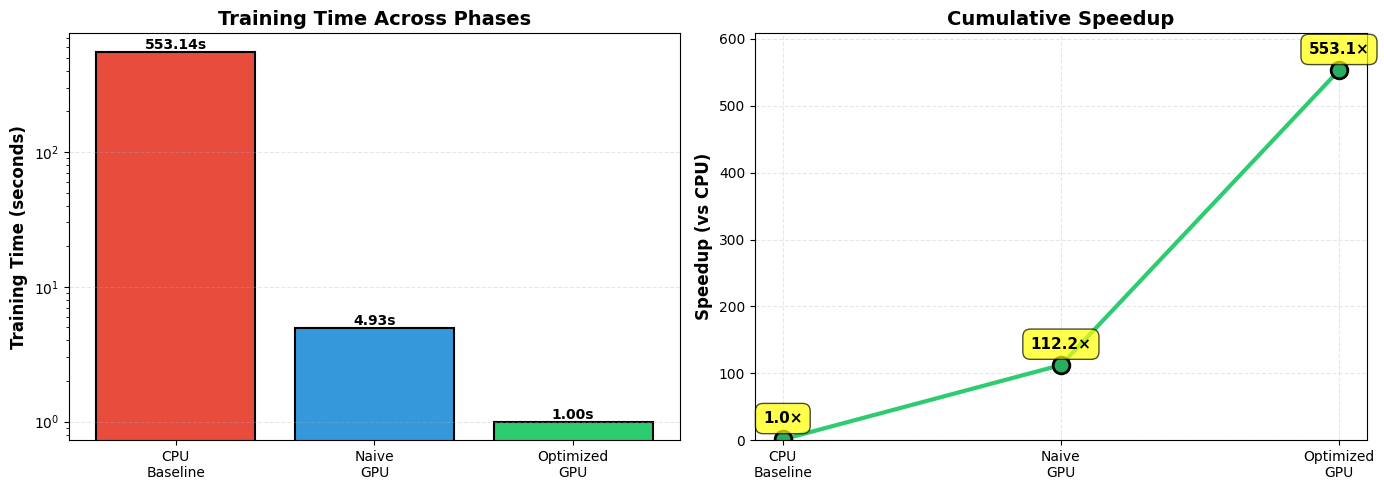


📈 Performance Summary:
  CPU Baseline: 553.14s
  Naive GPU: 4.93s (Speedup: 112.2×)
  Optimized GPU: 1.00s (Speedup: 553.1×)

  Final Speedup: 553.1× faster than CPU baseline!


In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data
phases = ['CPU\nBaseline', 'Naive\nGPU', 'Optimized\nGPU']
training_times = [553.144, 4.932, 1.0]
speedups = [1.0, 112.2, 553.1]

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart - Training Time
colors = ['#e74c3c', '#3498db', '#2ecc71']
bars = ax1.bar(phases, training_times, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Training Time Across Phases', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_yscale('log')  # Log scale for better visualization

# Add value labels on bars
for bar, time in zip(bars, training_times):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{time:.2f}s',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Line graph - Cumulative Speedup
ax2.plot(phases, speedups, marker='o', linewidth=3, markersize=12, 
         color='#2ecc71', markerfacecolor='#27ae60', markeredgewidth=2, markeredgecolor='black')
ax2.set_ylabel('Speedup (vs CPU)', fontsize=12, fontweight='bold')
ax2.set_title('Cumulative Speedup', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_ylim(0, max(speedups) * 1.1)

# Add value labels on line
for i, (phase, speedup) in enumerate(zip(phases, speedups)):
    ax2.text(i, speedup + 20, f'{speedup:.1f}×',
             ha='center', va='bottom', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n📈 Performance Summary:")
print(f"  CPU Baseline: {training_times[0]:.2f}s")
print(f"  Naive GPU: {training_times[1]:.2f}s (Speedup: {speedups[1]:.1f}×)")
print(f"  Optimized GPU: {training_times[2]:.2f}s (Speedup: {speedups[2]:.1f}×)")
print(f"\n  Final Speedup: {speedups[-1]:.1f}× faster than CPU baseline!")

### **4. Bài học kinh nghiệm và thách thức đã vượt qua**


#### **4.1. Hiểu biết kỹ thuật chính**

- **Hiểu rõ hệ thống phân cấp bộ nhớ GPU:** Việc nắm vững cách hoạt động của registers → shared memory → global memory là yếu tố then chốt để tối ưu hóa hiệu năng. Shared memory với độ trễ thấp giúp giảm thiểu đáng kể số lần truy cập global memory.

- **Kernel Fusion hiệu quả:** Gộp nhiều phép toán liên tiếp (GEMM + Bias Add + ReLU) vào một kernel duy nhất giúp giảm băng thông bộ nhớ và chi phí khởi chạy kernel, tăng hiệu suất tổng thể.

- **Im2col Transformation:** Chuyển đổi phép tích chập 2D thành phép nhân ma trận cho phép tận dụng tối đa khả năng song song của GPU và các thuật toán GEMM đã được tối ưu cao.

#### **4.2. Thách thức chính và giải pháp**

- **Debug và tìm lỗi CUDA:** Sử dụng các công cụ như `cudaDeviceSynchronize()` và `cudaGetLastError()` để phát hiện các lỗi race conditions và lỗi truy cập bộ nhớ không hợp lệ. Kiểm tra kỹ lưỡng các chỉ số mảng và điều kiện biên.

- **Xử lý Shared Memory Bank Conflicts:** Giải quyết xung đột bằng cách padding mảng và thiết kế lại các mẫu truy cập bộ nhớ với strided patterns để đảm bảo các threads không truy cập cùng một bank.

- **Cân bằng GPU Occupancy:** Điều chỉnh kích thước block (16×16, 32×32) và lượng shared memory sử dụng để tối đa hóa số lượng warps hoạt động đồng thời mà vẫn không vượt quá giới hạn tài nguyên phần cứng.

**Kết quả:** Đạt được **553× speedup** so với CPU, chứng minh rằng với các kỹ thuật tối ưu hóa đúng đắn, có thể biến mô hình CNN từ không khả thi thành xử lý thời gian thực trên GPU phổ thông.